# Capstone2 Modeling Mental Health Dataset

## Table of Contents
- [1. Overview](#1.-Overview)
- [2. Import Libraries](#2.-Import-Libraries)
- [3. Load Data](#3.-Load-Data)
- [4. Analyze Data](#4.-Analyze-Data)
- [5. Preparing the Data](#5.-Preparing-the-Data)
- [6. Modeling](#6.-Modeling)
    - [6.1 Global Model](#6.1-Global-Model)
        -  [6.1.1 Logistic Regression](#6.1.1-Logistic-Regression)
        -  [6.1.2 Random Forest](#6.1.2-Random-Forest)
        -  [6.1.3 LightGBM](#6.1.3-LightGBM)
        -  [6.1.4 XGBoost](#6.1.4-XGBoost)
        -  [6.1.5 Check for model overfitting K-fold Cross-Validation](6.1.6-Check-for-model-overfitting-K---fold-Cross---Validation)
        -  [6.1.6 Top 10 Features Influencing Model Prediction](#6.1.6-Top-10-Features-InfluencingModel-Prediction)
        -  [6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds](#6.1.7-Trade---off-Analysis:-True-Positives-and-False-Negatives-at-Different-Thresholds)
    - [6.2 Country Models](#6.2-Segmented-Country-Models)
        - [6.2.1 Evaluating Performance using LogisticRegression](#6.2.1-Evaluating-Performance-using-LogisticRegression)
        - [6.2.2 Review](#6.2.2-Review)
- [7. Summary](#7.-Summary)

## 1. Overview

The focus of the mental health modeling project is to develop a predictive model that identifies individuals likely to need mental health support. This analysis is based on a comprehensive dataset of categorical features, encompassing over 290,000 observations. Key factors considered in the model include demographics, mental health conditions, sentiment analysis scores, and psychological indicators.

The project builds upon prior analysis and base modeling using logistic regression for both the global and segmented models. The results include an accuracy of 0.69 on the global model with a 0.76 AUC, and for the high-performance segment, accuracy of 0.69 and 0.73 AUC. The lower-performing segment showed 0.54 Accuracy and 0.55 AUC.

In the modeling phase, we will implement XGBoost, LightGBM, and Random Forest algorithms, focusing on fine-tuning hyperparameter settings to enhance performance. We will also explore stacking approach to combine the models for better results. We will also create separate models for the high and low segments to address their specific needs and assess how these can be integrated with the global model to improve prediction performance.

To ensure the reliability of our models, we will expand our evaluation metrics beyond accuracy and AUC, and include cross-validation using weighted F1 for the scoring. We will also apply k-fold cross-validation to test the model for overfitting.

## 2. Import Libraries

In [36]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

%autoreload 2

import libs.data_utils as utils

# Common runtime settings
utils.random_state=42
utils.verbose=1

## 3. Load Data

In [38]:
mh_df = pd.read_csv('MentalHealthDataset.csv')

## 4. Analyze Data

In [39]:
mh_df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


## 5. Preparing the Data

#### Resolving Duplicates

But first, we need to deal with 'Timestamp'. Dropping the column outright causes 78% of the observations to be duplicated. We need to create new features out of the timestamp components to retain uniqueness among the rows. 

The new feature may enhance the model's ability to capture temporal patterns and improve performance.

In [40]:
df = mh_df.copy()
# Pre-check - count duplicates with 'Timestamp' as index.
print(f'Duplicates before dropping "Timestamp": {df.duplicated().sum()}')

# Load data using our MentalHealthData processing object.
# The first step in the process is to drop the 'Timestamp' Column.
# 
mh_o = utils.MentalHealthData(df)
mh_o.train_test_split() # Split with default target 'treatment'

print(f'Duplicates after dropping "Timestamp": {mh_o.X_train.duplicated().sum()}')
print(f'\nX_train: {mh_o.X_train.shape}, x_test: {mh_o.x_test.shape}')
print(f'y_train: {mh_o.y_train.shape}, y_test: {mh_o.y_test.shape}')
print(f'y: {mh_o.y.shape}')

Duplicates before dropping "Timestamp": 2313
Duplicates after dropping "Timestamp": 208718

X_train: (273596, 63), x_test: (18768, 63)
y_train: (273596,), y_test: (18768,)
y: (292364,)


In [41]:
# Make sure test and train columns match
mh_o.X_train.columns.difference(mh_o.x_test.columns)

Index([], dtype='object')

As seen in the output, duplicates went from **2313** to **208718** after dropping **'Timestamp'**.
Reducing the number of unique observations to **83646** out of the **292364** total observations in the dataset.

To keep the uniqueness of most of the observation we will create new features from 'Timestamp' as **'year'**, 
**'month'**, **'day'**, **'hour'**, and **'min'**. 

We will drop 'Timestamp' after creating the new features.


The next step will update and create the new features and apply transformations to our data.

Now we're ready to apply additional pre-processing and onto modeling

In [42]:
# Now were ready to apply pre-processing and modeling
print(f'Duplicates before dropping "Timestamp": {mh_df.duplicated().sum()}')
# Run feature transformation, feature engineering
mh_o = utils.mental_health_instance(mh_df.copy())

print(f'Duplicates after dropping "Timestamp": {mh_o.X_train.duplicated().sum()}')
print(f'\nX_train: {mh_o.X_train.shape}, x_test: {mh_o.x_test.shape}')
print(f'y_train: {mh_o.y_train.shape}, y_test: {mh_o.y_test.shape}')
print(f'y: {mh_o.y.shape}')


Duplicates before dropping "Timestamp": 2313
Duplicates after dropping "Timestamp": 2510

X_train: (206042, 68), x_test: (86322, 68)
y_train: (206042,), y_test: (86322,)
y: (292364,)


Observe that we have more unique observations than duplicates after applying the changes.

We also retained the duplicates and took special care to keep them out of the test data set during pre-processing.

In [43]:
mh_o.get_data().head()

,family_history,treatment,Coping_Struggles,year,month,day,hour,minute,Gender_Male,Country_Belgium,...,Mood_Swings_Low,Mood_Swings_Medium,Work_Interest_No,Work_Interest_Yes,Social_Weakness_No,Social_Weakness_Yes,mental_health_interview_No,mental_health_interview_Yes,care_options_Not_sure,care_options_Yes
0,0,1,0,8,8,27,11,29,0,0,...,0,1,1,0,0,1,1,0,1,0
1,1,1,0,8,8,27,11,31,0,0,...,0,1,1,0,0,1,1,0,0,0
2,1,1,0,8,8,27,11,32,0,0,...,0,1,1,0,0,1,1,0,0,1
3,1,1,0,8,8,27,11,37,0,0,...,0,1,1,0,0,1,0,0,0,1
4,1,1,0,8,8,27,11,43,0,0,...,0,1,1,0,0,1,1,0,0,1


In [44]:
# Check stats
display(mh_o.X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 206042 entries, 246829 to 291985
Data columns (total 68 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   family_history                   206042 non-null  int64
 1   Coping_Struggles                 206042 non-null  int64
 2   year                             206042 non-null  int64
 3   month                            206042 non-null  int64
 4   day                              206042 non-null  int64
 5   hour                             206042 non-null  int64
 6   minute                           206042 non-null  int64
 7   Gender_Male                      206042 non-null  int64
 8   Country_Belgium                  206042 non-null  int64
 9   Country_Bosnia_and_Herzegovina   206042 non-null  int64
 10  Country_Brazil                   206042 non-null  int64
 11  Country_Canada                   206042 non-null  int64
 12  Country_Colombia              

None

## 6. Modeling

A custom library was developed to separate code-intensive operations and emphasize the presentation of the modeling strategy in this notebook. In the following sections, we will utilize **libs/data_utils.py** to perform the necessary steps to train and evaluate the performance of four pre-selected models:

- Logistic Regresssion
- LightGBM
- XGBoost
- Random Forest

Strategy for Each Model:

- Evaluate the optimized precision and recall thresholds to identify the balanced threshold using the F1 score.
- Get the optimized hyper-parameter values for each classifier using Bayesian Optimization.
- Train the models using the best parameter values obtained in the previous step.
- Use the top-performing models from LightGBM, XGBoost, and Random Forest as base models for a StackingClassifier.
- Train the StackingClassifier with Logistic Regression as the final learner.
- Record and assess the performance metrics for each model.

### 6.1 Global Model

**Evaluating the Precision/Recall Optimal Threshold**

In each evaluated model we specify a balanced class weights as well as specify F1 score as the metric to identify the optimized precision and recall, as well as the optimal threshold value.

For mental health treatment prediction, **recall** is important to correctly predict if a patient needs help. Missing someone who needs treatment can be problematic. We want to make sure the model finds all the right people.

The **F1 score** balances between catching everyone who needs treatment while avoiding too many false alarms. It's useful when we care about both finding the right people and not over-predicting.

**Trade-offs:**
By analyzing the evaluation results (recall, precision, F1 score), the stake holders can decide which trade-offs make sense for a specific use case.

#### 6.1.1 Logistic Regression


Confusion Matrix:
[[25536 17449]
 [ 6718 36619]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.59      0.68     42985
           1       0.68      0.84      0.75     43337

    accuracy                           0.72     86322
   macro avg       0.73      0.72      0.72     86322
weighted avg       0.73      0.72      0.72     86322


Log loss: 10.091
Optimal Threshold: 0.343


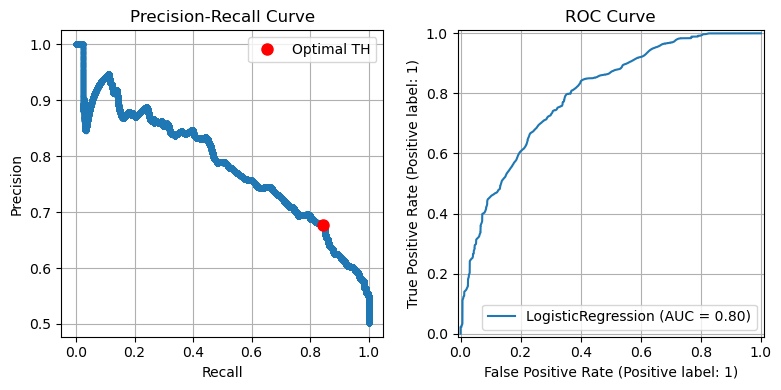

In [45]:
def get_LR_model():
  return LogisticRegression(class_weight='balanced', max_iter=1600, n_jobs=-1, random_state=utils.random_state)

_ = utils.evaluate_precision_recall_optimized_model(mh_o, get_LR_model, metric='f1')

#### 6.1.2 Random Forest

Confusion Matrix:
[[42304   681]
 [ 1342 41995]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     42985
           1       0.98      0.97      0.98     43337

    accuracy                           0.98     86322
   macro avg       0.98      0.98      0.98     86322
weighted avg       0.98      0.98      0.98     86322


Log loss: 0.845
Optimal Threshold: 0.520


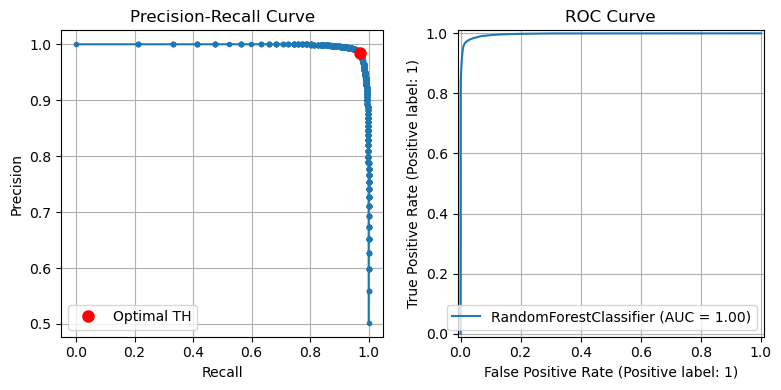

In [46]:
# Evaluate RandomForest model
def get_RF_model():
  return RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=utils.random_state)

_ = utils.evaluate_precision_recall_optimized_model(mh_o, get_RF_model, metric='f1')

#### 6.1.3 LightGBM

Confusion Matrix:
[[42373   612]
 [  610 42727]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42985
           1       0.99      0.99      0.99     43337

    accuracy                           0.99     86322
   macro avg       0.99      0.99      0.99     86322
weighted avg       0.99      0.99      0.99     86322


Log loss: 0.510
Optimal Threshold: 0.436


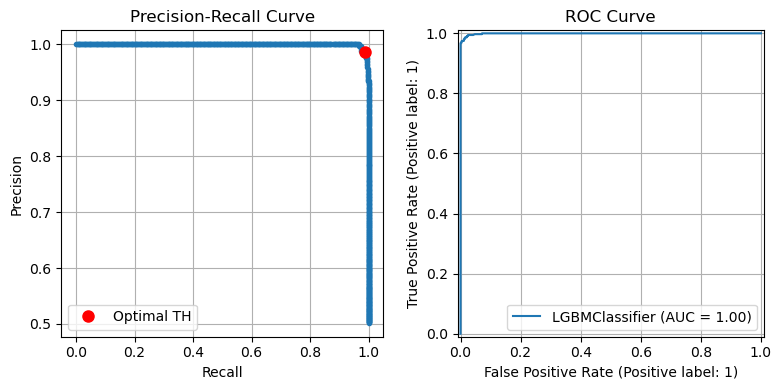

In [47]:
# Evaluate LGBM
def get_LGBM_model():
  return LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=utils.random_state, verbose=0)

_ = utils.evaluate_precision_recall_optimized_model(mh_o, get_LGBM_model, metric='f1')

#### 6.1.4 XGBoost

Confusion Matrix:
[[42869   116]
 [    0 43337]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42985
           1       1.00      1.00      1.00     43337

    accuracy                           1.00     86322
   macro avg       1.00      1.00      1.00     86322
weighted avg       1.00      1.00      1.00     86322


Log loss: 0.048
Optimal Threshold: 0.430


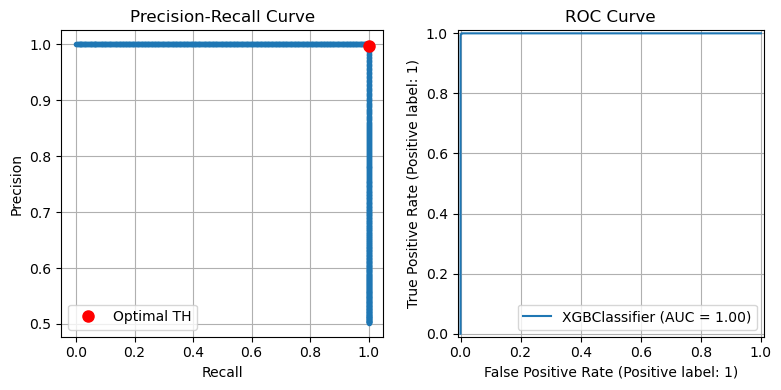

In [48]:
# Evaluate XGB
def get_XGB_model():
  scale_pos_weight = sum(mh_o.y_train == 0) / sum(mh_o.y_train == 1)
  return XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=utils.random_state)

fitted_model = utils.evaluate_precision_recall_optimized_model(mh_o, get_XGB_model, metric='f1')

The predictive performance of the XGBoost, LightGBM, and Random Forest models is strong, and no further optimization is needed. XGBoost is the best model for recall optimization, with key findings:

- No false negatives and 116 false positives, indicating excellent recall.
- Log loss is 0.048, the lowest among models, showing high confidence in predictions.
- Optimal threshold is 0.430.
- Both precision and recall for class 1 are at 100%, meaning the model is highly accurate in identifying true positives.
- Overall accuracy is 100%.

#### 6.1.5 Check for model overfitting K-fold Cross-Validation

In [49]:
mh = utils.mental_health_instance(mh_df.copy())
scale_pos_weight = sum(mh.y == 0) / sum(mh.y == 1)
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=utils.random_state)

kf = KFold(n_splits=15, shuffle=True, random_state=utils.random_state)

# Evaluate xgboost on train data
cv_scores = cross_val_score(xgb_model, mh.X_train, mh.y_train, scoring='f1')

print(f'Train data CV scores: {cv_scores}')
print(f'Train data Mean CV score: {np.mean(cv_scores):.4f}')
print(f'Train data CV scores std: {np.std(cv_scores):.4f}')

# Evaluate xgboost on test data
cv_scores = cross_val_score(xgb_model, mh.x_test, mh.y_test, scoring='f1')

print(f'\nTest data CV scores: {cv_scores}')
print(f'Test data Mean CV score: {np.mean(cv_scores):.4f}')
print(f'Test data CV scores std: {np.std(cv_scores):.4f}')

Train data CV scores: [0.99870361 0.99849178 0.99747602 0.99583484 0.99757858]
Train data Mean CV score: 0.9976
Train data CV scores std: 0.0010

Test data CV scores: [0.99855583 0.99861368 0.99774501 0.9982084  0.99855982]
Test data Mean CV score: 0.9983
Test data CV scores std: 0.0003


The XGBoost model performance is consistent across different folds and is not overfitting.

This suggests XGBoost is performing exceptionally well, especially for identifying all individuals who need treatment.

#### 6.1.6 Top 5 Features with Strong Positive and Negative Influence on Model Prediction 

In [50]:
shap_df = utils.top_model_influencers(fitted_model, mh_o.x_test, n_influencers=5)
shap_df.style.hide(axis='index')

Feature,Score
care_options_Yes,0.049648
family_history,0.030055
Gender_Male,0.021771
Country_Canada,0.008508
Country_New_Zealand,0.007661
Country_Italy,-0.009489
Country_Israel,-0.012308
self_employed_Yes,-0.012440
Country_France,-0.014492
mental_health_interview_No,-0.043055


#### 6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds

In [51]:
trade_offs = utils.analyze_tradeoffs(mh_o, get_XGB_model)
trade_offs.style.hide(axis='index')

Threshold,Precision,Recall,True Positives,False Negatives
0.429932,0.997,1.000,43337,0
0.471660,0.997,0.997,43217,120
0.498848,1.000,0.994,43096,241
0.577143,1.000,0.992,42977,360
0.657853,1.000,0.989,42851,486
0.681693,1.000,0.986,42718,619
0.701262,1.000,0.983,42598,739
0.706736,1.000,0.980,42479,858
0.709127,1.000,0.977,42357,980
0.803280,1.000,0.975,42240,1097


### 6.2 Country Models

#### 6.2.1 Evaluating Performance using XGBoost 

The following steps required the proper segregation of country specific data:
- Create a country specific subset from the mental health dataset using:

  ```
    df_country = df[df['Country'] == country_name]
  ```

- Pre-process data: Transform, feature-engineering
- Train/test split country data.
- Run predictions
- Get values:
  - Accuracy
  - AUC
  - Cross-Validation mean and std score (scoring used is weighted F1, cv=5)

In [52]:
# Train/evaluate models
report_df = utils.evaluate_by_feature_country(mh_df.copy(), get_XGB_model)

In [53]:
report_df.style.hide(axis='index')

Country,Accuracy,AUC,CV-F1 (mean),CV-F1 (std),Other
United States,0.998,1.000,0.993,0.009,
Poland,,,,,One class found: [No]. >1 class is required for modeling.
Australia,1.000,1.000,1.000,0.000,
Canada,1.000,1.000,1.000,0.000,
United Kingdom,1.000,1.000,1.000,0.000,
South Africa,1.000,1.000,1.000,0.000,
Sweden,1.000,1.000,1.000,0.000,
New Zealand,1.000,1.000,1.000,0.000,
Netherlands,1.000,1.000,1.000,0.000,
India,1.000,1.000,1.000,0.000,


#### 6.2.2 Review

- The countries like the US and the UK show excellent performance. Countries like Australia, South Africa, and others achieved perfect scores.

- **One-Class Issue:** Several countries, including Poland, Belgium, and France, are with only one class being present in the dataset. This prevents meaningful modeling. This indicates a potential data imbalance, or a lack of diverse cases in those regions.

- **Requires Further Analysis:** Countries with perfect scores needs a closer examination of the dataset to understand if the models are overly fitted or if the data truly represents a distinct population without variability.

- **Next Steps:** Consider enhancing datasets for countries facing the one-class issue to include more diverse cases.

## 7. Summary

The objective of this notebook is to model and predict the likelihood of an individual to need mental health support based on several demographic and mental health factors.

The observations from the country models may have significant effect on the global model, in terms of performance, and feature selection. 

Considerations:

- The single-class problem in some countries need consideration of data representation in the global model. If a large portion of the dataset is not balanced, the global model may poorly predict results across countries.
- The global model is a single architecture, consider making it more modular to accommodate different countries. For this, using ensemble methods to combine outputs from country-specific models may enhance the overall performance.
- Incorporate new data, features, methods. The new information may enhance model accuracy over time.
Unique patterns may be found from the country analysis, explore using a hybrid model and the global model serving as a baseline and country models are used to tune predictions.


The knowledge gained from country-specific modeling should be the main factor to refine the global model. By studying the unique features of different regions, the global model can be made robust and effective across different contexts. 

The need for continuous evaluaton and adaption based on these observations will be necessary to ensuring continued improvement in predicting the need for mental health support.